# Exploratory Data Analysis 2

In this first notebook, I looked at differences in the overall essays from each class. In this notebook, I dive deeper and ask questions about the physical words and the language structure of each essay.

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import sqlalchemy
from tqdm import tqdm
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
from torchtext.data import get_tokenizer
from torchtext.data.utils import ngrams_iterator
import spacy
from transformers import pipeline, AutoTokenizer
from sklearn.model_selection import train_test_split

# Adding the credentials
sys.path.append('../')
from credentials import credentials

# Making pandas tqdm
tqdm.pandas()

In [2]:
# Creating the database engine 
connector_string = f'mysql+mysqlconnector://{credentials["user"]}:{credentials["password"]}@{credentials["host"]}/AuthenticAI'
db_engine = sqlalchemy.create_engine(connector_string,echo=True)

# Connecting to the database
db_conn = db_engine.connect()

2024-01-12 02:08:30,000 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2024-01-12 02:08:30,001 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-01-12 02:08:30,004 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2024-01-12 02:08:30,005 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-01-12 02:08:30,007 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2024-01-12 02:08:30,009 INFO sqlalchemy.engine.Engine [raw sql] {}


## How many unique words per essay?

According to papers, it seems that human text tends to have more unique words than LLM generated text. Furthermore, the ratio of unique words to total words tends to be higher. Researchers attribute this result to LLMs being more like dreams/mimickers of human text so they are very rule based and not "conscious". In this section, I see how many unique words each essay has, what the ratio to unique words to total words is for each essay. 

In [3]:
# Getting the tokenizer
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

In [4]:
# Making a function to get the unique words
def get_unique_words(text:str) -> int:
    # Tokenize the text
    tokenized = set(tokenizer.tokenize(text))
    return len(tokenized)

In [5]:
# Getting the data 
data = pd.DataFrame([row for row in db_conn.execute(sqlalchemy.text('select * from essays;'))])
data

2024-01-12 02:08:33,621 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-01-12 02:08:33,622 INFO sqlalchemy.engine.Engine select * from essays;
2024-01-12 02:08:33,623 INFO sqlalchemy.engine.Engine [generated in 0.00287s] {}


,row_id,prompt,essay,word_count,LLM_written
0,1,Write a letter to your state senator in which ...,"Dear State Senator,\n\nI'm writting to you tod...",291,1
1,2,Some schools require students to complete summ...,"Uh, hi! So, like, summers are, like, awesome r...",311,1
2,3,"When people ask for advice, they sometimes tal...","When peoples ask for advices, they sometimes t...",333,1
3,4,Many people believe that arts education is ess...,I think art edukation is super impotent for ki...,308,1
4,5,"In recent years, there has been a push towards...",I think we should totally switch to renewable ...,307,1
...,...,...,...,...,...
49924,49925,Provide the full text for the following summar...,Selected Works of Lu Hsun Research Paper\n\nFi...,2631,0
49925,49926,Create the inputted essay that provided the fo...,Self-Understanding Role in Organizational Beha...,1061,0
49926,49927,Write the full essay for the following summary...,“Sequoia Gardens” by Ernest Finney Literature ...,1134,0
49927,49928,Convert the following summary back into the or...,Service Marketing: Food Market Essay\n\nTable ...,555,0


In [6]:
# Applying the unique word count function
data['unique_word_count'] = data['essay'].progress_apply(get_unique_words)

  1%|          | 365/49929 [00:00<00:13, 3646.97it/s]

100%|██████████| 49929/49929 [00:20<00:00, 2461.55it/s]


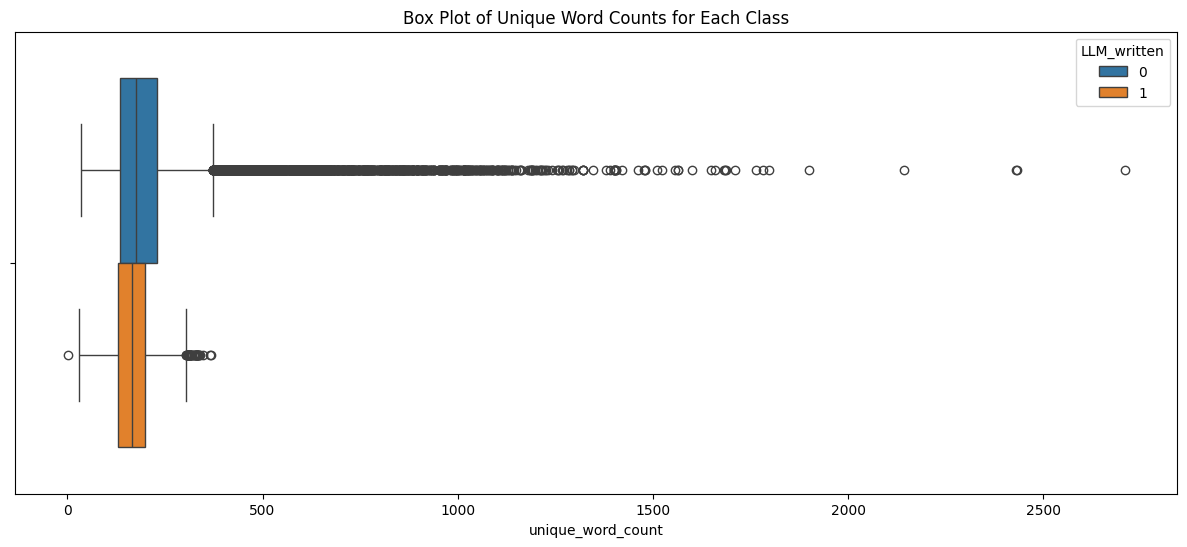

In [7]:
# Making a bar plot
plt.figure(figsize=(15,6))
sns.boxplot(data,x='unique_word_count',hue='LLM_written')
plt.title('Box Plot of Unique Word Counts for Each Class')
plt.show()

This box plot shows that the LLM written essays have little outliers in terms of the number of unique words whilst the student essays have a lot of outliers in terms of unique words in the essay. 

In [8]:
# Looking at the describe statistics 
print('Student Unique Words')
print(data[data['LLM_written'] == 0]['unique_word_count'].describe())
print()
print('LLM Unique Words')
print(data[data['LLM_written'] == 1]['unique_word_count'].describe())

Student Unique Words
count    31856.000000
mean       204.574837
std        129.898618
min         36.000000
25%        136.000000
50%        177.000000
75%        231.000000
max       2708.000000
Name: unique_word_count, dtype: float64

LLM Unique Words
count    18073.000000
mean       163.999945
std         49.783137
min          1.000000
25%        129.000000
50%        166.000000
75%        199.000000
max        369.000000
Name: unique_word_count, dtype: float64


From the descriptive statistics, I see that the student essays tend to have a higher average number of unique words. However, this value may be skewed due to many outliers. Specifically, one essays seems to have as many as 2708 unique words. That is much higher than the the LLM essays. THe LLM essays, on the other hand, have much lower number of unique words as evidenced by the mean and standard deviation. Furthermore, the maximum number of unique words for a LLM is lower. However, is this because that student essays tend to be longer? Obviously, if an essay is longer there are more opportunities to include unique words. To close off this analysis, I will need to look at the ratio between unique words and total words for each essay.

In [9]:
data['unique_to_total'] = data['unique_word_count'] / data['word_count']

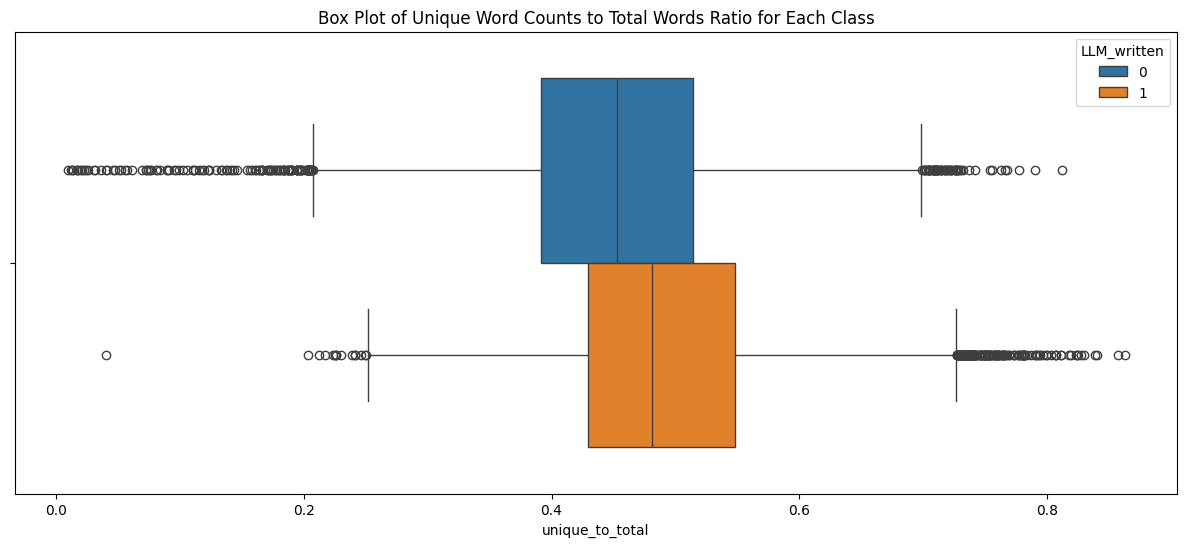

In [10]:
# Making a bar plot
plt.figure(figsize=(15,6))
sns.boxplot(data,x='unique_to_total',hue='LLM_written')
plt.title('Box Plot of Unique Word Counts to Total Words Ratio for Each Class')
plt.show()

In [11]:
# Looking at the describe statistics 
print('Student Unique Words to Total')
print(data[data['LLM_written'] == 0]['unique_to_total'].describe())
print()
print('LLM Unique Word to Total')
print(data[data['LLM_written'] == 1]['unique_to_total'].describe())

Student Unique Words to Total
count    31856.000000
mean         0.453038
std          0.090548
min          0.009246
25%          0.391618
50%          0.453050
75%          0.514572
max          0.812500
Name: unique_to_total, dtype: float64

LLM Unique Word to Total
count    18073.000000
mean         0.492315
std          0.090620
min          0.040000
25%          0.429043
50%          0.480962
75%          0.548117
max          0.862745
Name: unique_to_total, dtype: float64


From this analysis, it seems that the first finding, student essays have more unique words than LLM essays, was flawed. The box plot shows that the LLM written essays tend to have more unique words in comparison to the total amount of words whereas a student written essay tends to have less unique words in comparison to total words. However, one flaw with this comparison is that student essays tend to be larger. Thus, for the unique word count / total word count to be high, unique word count needs to be much higher. 

Both experiments realize great findings but there is a great flaw in both. To mitigate this flaw, I will look at essays that are less than 400 words (the median of word count for student essays).

In [12]:
smaller_word_count = data[data['word_count'] <= 400]
smaller_word_count['LLM_written'].value_counts()

LLM_written
0    15898
1    12015
Name: count, dtype: int64

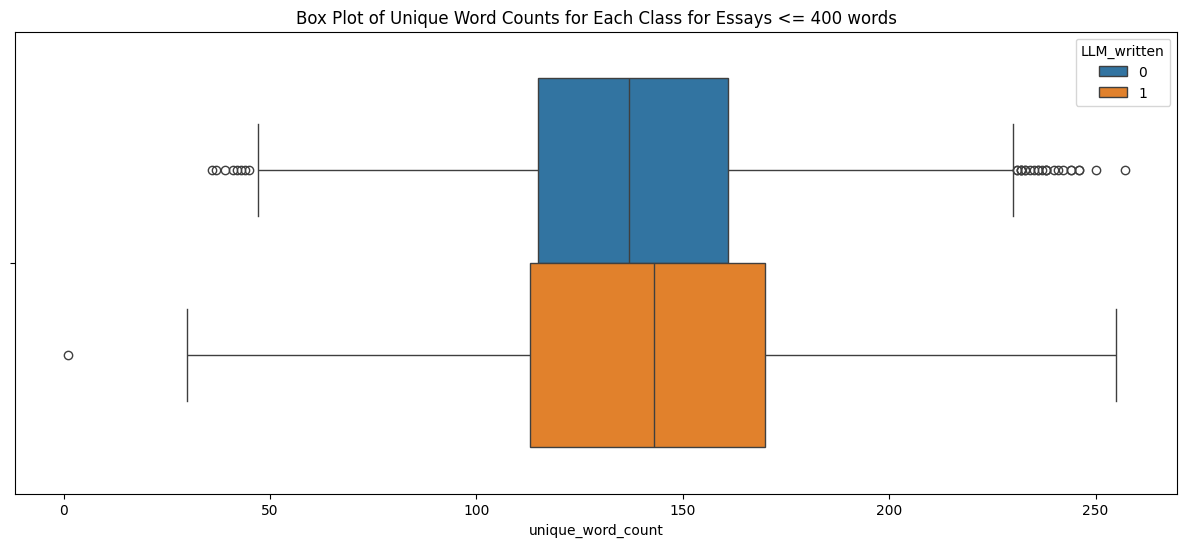

In [13]:
# Making a box plot
plt.figure(figsize=(15,6))
sns.boxplot(smaller_word_count,x='unique_word_count',hue='LLM_written')
plt.title('Box Plot of Unique Word Counts for Each Class for Essays <= 400 words')
plt.show()

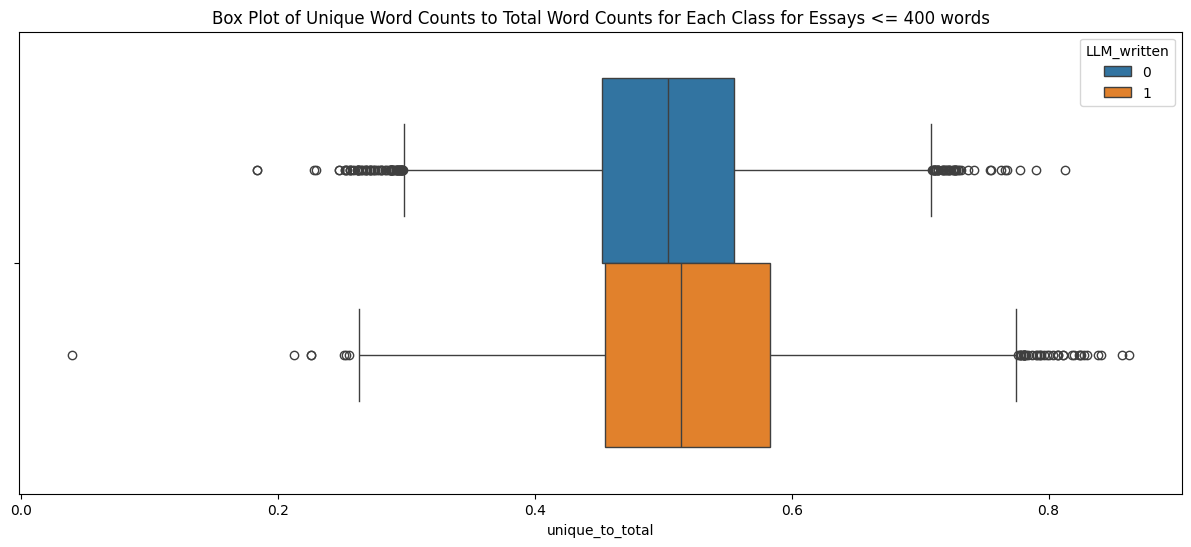

In [14]:
# Making a bar plot
plt.figure(figsize=(15,6))
sns.boxplot(smaller_word_count,x='unique_to_total',hue='LLM_written')
plt.title('Box Plot of Unique Word Counts to Total Word Counts for Each Class for Essays <= 400 words')
plt.show()

Analysis:

If I cap the essay word at 400, I see that I am left with about 15000 student essays and 12000 LLM written essays. I chose 400 since that is the median of the word count of the student essays. If I perform the same analysis, I can see that LLM written essays tend to have more unique words and a higher unique word ratio. While the first experiment showed that student written essays tend to have more unique words. This finding can be attributed to the fact that student written essays are much longer than LLM written ones. Hence, there is more room to add words. 

TLDR: A high unique word count + a high unique word count / total_word_count indicates that the essay might be written by a LLM. I can utilize these 2 findings as features.

## How many stop words does per essay? Is there a difference between a LLM and a student written essay?

Stop words are defined as "filler" words such as the, a, I. These words don't provide much context to a piece of text. In this experiment, I see if there is a difference in the number of stop words for a LLM and a student written essay. I also see the ratio of stop words to total words for each essay to determine how much of a factor total_word_count makes. 

In [15]:
# Getting the list of stop words
nltk.download('stopwords')
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jinalshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# Making a function to count the stop words for each essay
def stop_word_count(text:str) -> int:
    # Tokenize the text
    tokenized = tokenizer.tokenize(text)
    count = 0

    for word in tokenized:
        if word in stop_words:
            count += 1
    
    return count

In [17]:
# Getting the stop word count
data['stop_word_count'] = data['essay'].progress_apply(stop_word_count)

100%|██████████| 49929/49929 [02:02<00:00, 407.28it/s] 


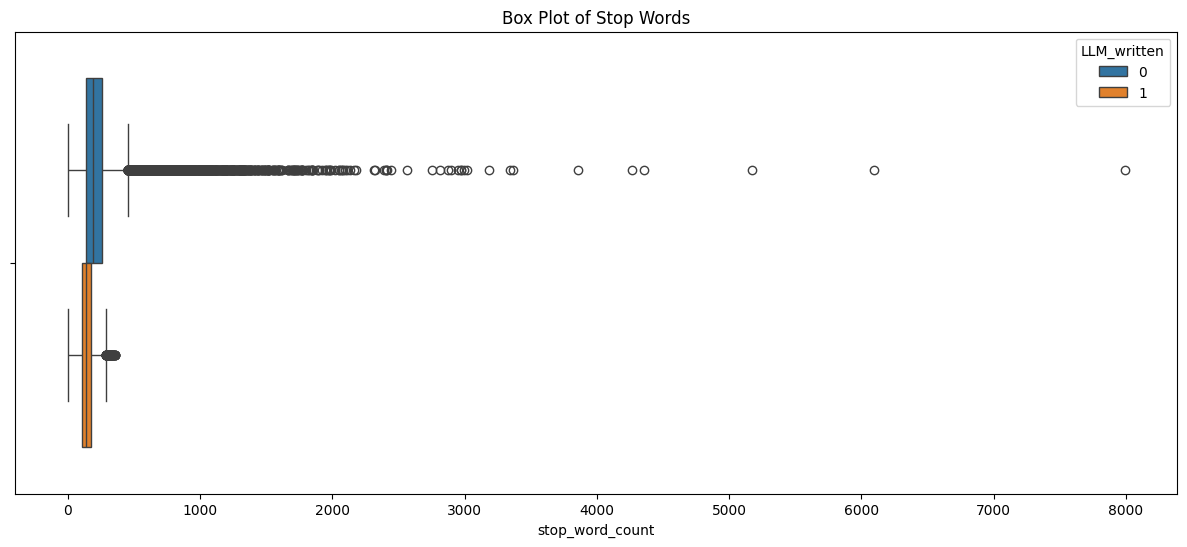

In [18]:
# Making a box plot
plt.figure(figsize=(15,6))
sns.boxplot(data,x='stop_word_count',hue='LLM_written')
plt.title('Box Plot of Stop Words')
plt.show()

In [19]:
# Looking at the describe statistics 
print('Student Stop Words')
print(data[data['LLM_written'] == 0]['stop_word_count'].describe())
print()
print('Student Stop Word')
print(data[data['LLM_written'] == 1]['stop_word_count'].describe())

Student Stop Words
count    31856.000000
mean       228.544638
std        190.343216
min          0.000000
25%        135.000000
50%        191.000000
75%        263.000000
max       7989.000000
Name: stop_word_count, dtype: float64

Student Stop Word
count    18073.000000
mean       143.845128
std         52.410970
min          0.000000
25%        105.000000
50%        142.000000
75%        178.000000
max        360.000000
Name: stop_word_count, dtype: float64


In [20]:
# Stop word ratio
data['stop_word_ratio'] = data['stop_word_count'] / data['word_count']

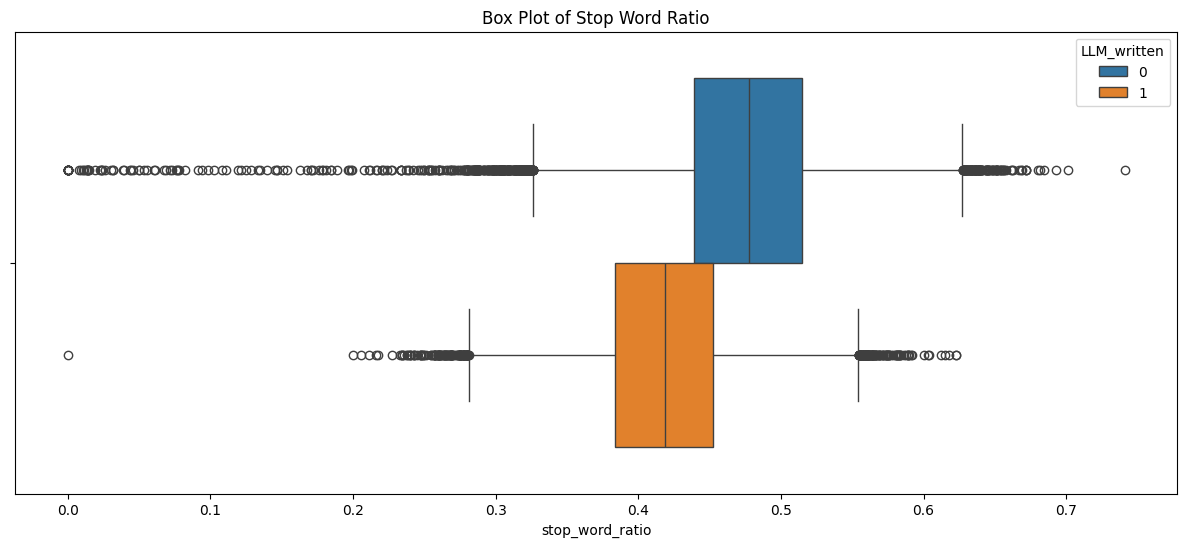

In [21]:
# Making a box plot
plt.figure(figsize=(15,6))
sns.boxplot(data,x='stop_word_ratio',hue='LLM_written')
plt.title('Box Plot of Stop Word Ratio')
plt.show()

From this boxplot, it is clear that student essays include a higher ratio of stop words/total words. However, there are a lot of outliers that fall outside the first quartile. Initially, it seems like student essays tend to include more stop words. However, there are a lot of outliers. I want to see how much word_count impacts this. Will perform the same experiment on essays <= 400 words.

In [22]:
smaller_word_count = data[data['word_count'] <= 400]
smaller_word_count['LLM_written'].value_counts()

LLM_written
0    15898
1    12015
Name: count, dtype: int64

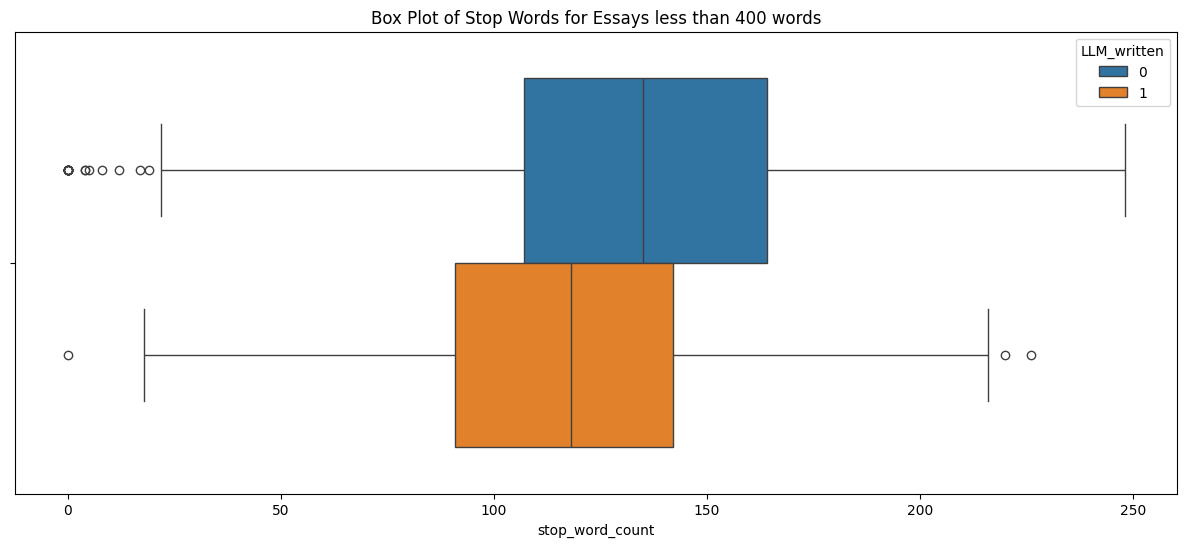

In [23]:
# Making a box plot
plt.figure(figsize=(15,6))
sns.boxplot(smaller_word_count,x='stop_word_count',hue='LLM_written')
plt.title('Box Plot of Stop Words for Essays less than 400 words')
plt.show()

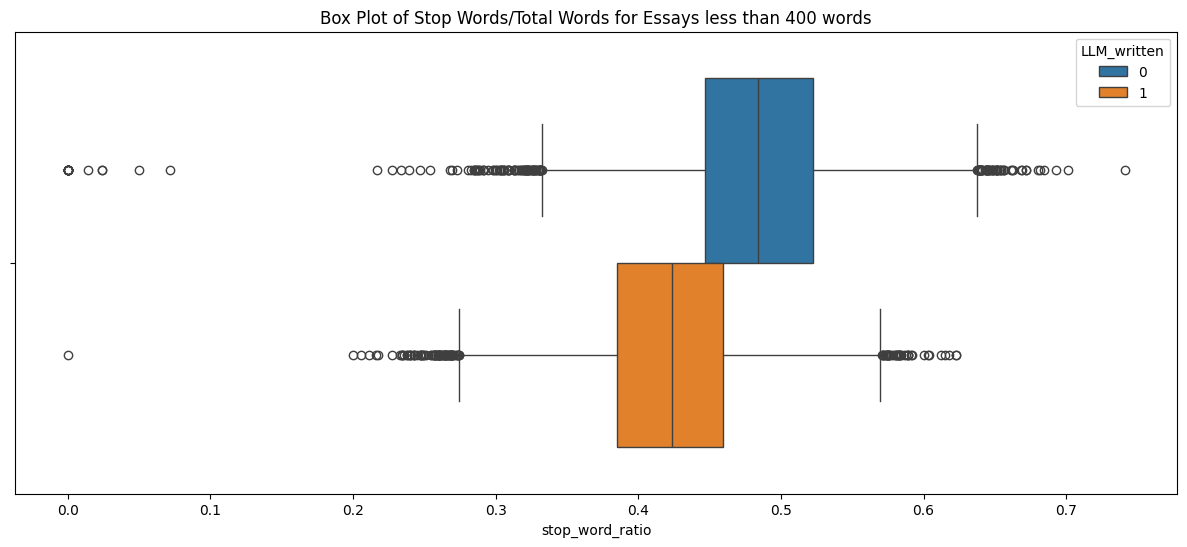

In [24]:
# Making a box plot
plt.figure(figsize=(15,6))
sns.boxplot(smaller_word_count,x='stop_word_ratio',hue='LLM_written')
plt.title('Box Plot of Stop Words/Total Words for Essays less than 400 words')
plt.show()

Analysis:

This experiment leads to simple results: Students tend to utilize more stop words than LLMs. This conclusion can be drawn when we look at the distribution of the stop_word_count for both classes. Even when we cap the word_count at 400, we can see that the median of stop word count is higher in the student essays. Furthermore, there is a higher ratio of stop words to total words in the student essays. This leads me to conclude that student essays tend to incorporate more stop words. This makes sense since the last experiment showed that LLMs tend to incorporate more unique words. 

TLDR: Include columns for stop word count and stop word to total word count.

## How does the counts of punctuation differ?

In this section, I want to analyze how punctuation differs between the 2 classes. Do students utilize more diverse punctuation? Is there is difference in the counts between each class?

In [25]:
# Getting the tokenizer
pytorch_tokenizer = get_tokenizer('spacy',language='en_core_web_sm')

In [26]:
# Functions for counting punctuations
# (?, !, ;, :)
def count_punc(text: str) -> int:
    tokenized_text = pytorch_tokenizer(text)
    count_q = 0
    count_ex = 0
    count_semi = 0
    count_col = 0
    for token in tokenized_text:
        if token == "?":
            count_q += 1
        elif token == "!":
            count_ex += 1
        elif token == ";":
            count_semi += 1
        elif token == ":":
            count_col += 1
    
    return count_q, count_ex,count_semi, count_col

In [27]:
# Making columns and adding to the dataframe
counts = data['essay'].progress_apply(count_punc)
data['count_question'] = [row[0] for row in counts]
data['count_exclamation'] = [row[1] for row in counts]
data['count_semi'] = [row[2] for row in counts]
data['count_colon'] = [row[3] for row in counts]
data.head()

  0%|          | 0/49929 [00:00<?, ?it/s]

100%|██████████| 49929/49929 [01:45<00:00, 471.75it/s] 


,row_id,prompt,essay,word_count,LLM_written,unique_word_count,unique_to_total,stop_word_count,stop_word_ratio,count_question,count_exclamation,count_semi,count_colon
0,1,Write a letter to your state senator in which ...,"Dear State Senator,\n\nI'm writting to you tod...",291,1,131,0.450172,137,0.470790,0,2,0,0
1,2,Some schools require students to complete summ...,"Uh, hi! So, like, summers are, like, awesome r...",311,1,121,0.389068,137,0.440514,3,4,0,0
2,3,"When people ask for advice, they sometimes tal...","When peoples ask for advices, they sometimes t...",333,1,155,0.465465,158,0.474474,0,1,0,0
3,4,Many people believe that arts education is ess...,I think art edukation is super impotent for ki...,308,1,130,0.422078,121,0.392857,0,0,0,0
4,5,"In recent years, there has been a push towards...",I think we should totally switch to renewable ...,307,1,146,0.475570,138,0.449511,0,2,0,0


In [28]:
print('Student')
print(data[data['LLM_written'] == 0][['count_question','count_exclamation','count_semi','count_colon']].describe())
print()
print('LLM')
print(data[data['LLM_written'] == 1][['count_question','count_exclamation','count_semi','count_colon']].describe())

Student
       count_question  count_exclamation    count_semi   count_colon
count    31856.000000       31856.000000  31856.000000  31856.000000
mean         0.717918           0.247175      0.331523      0.551701
std          1.523315           1.095986      1.532854      2.615727
min          0.000000           0.000000      0.000000      0.000000
25%          0.000000           0.000000      0.000000      0.000000
50%          0.000000           0.000000      0.000000      0.000000
75%          1.000000           0.000000      0.000000      0.000000
max         73.000000          67.000000     87.000000    115.000000

LLM
       count_question  count_exclamation    count_semi   count_colon
count    18073.000000       18073.000000  18073.000000  18073.000000
mean         0.214242           0.172799      0.064295      0.359044
std          0.781610           0.934122      0.356692      1.207527
min          0.000000           0.000000      0.000000      0.000000
25%          0.000000

Across the board, students tend to utilize every character of punctuation more. The means are higher, but the medians are the same. What is curious is that the max counts for these marks are much higher for students than for LLMs. This means that students tend to use punctuation more. If we compare some of them, we can see that for question marks and semi-colons, the mean is much higher for the student essays. The student essays also have a higher standard deviation for each mark. This means that the counts are more spread, leading me to believe that they can get very high in comparison to the LLM essays. 

TLDR: The counts of each the punctuation marks matter. Can use this as a feature. The higher the punctuation mark count, the more likely for a student essay. More question marks and semi-colons are big predictors.

## What n-grams separate each essay?

In this section, I want to see what n-grams separate each essay. Are there words and phrases that appear more in LLM essays than in student essays?

### Unigrams

I start with unigrams and work my way till tri-grams. 

In [29]:
# I can tokenize each essay and store the unigram counts in 2 fold, one for the student and one for the llm
unigrams = {}
tokenized_essays = data['essay'].progress_apply(lambda row: pytorch_tokenizer(row))

100%|██████████| 49929/49929 [01:30<00:00, 551.15it/s] 


In [30]:
# Iterating through each tokenized essay to get the unigrams
unigrams = {'student':{},'llm':{}}
labels = data['LLM_written'].tolist()
for index in tqdm(range(len(labels))):
    if labels[index] == 0:
        label = 'student'
    else:
        label = 'llm'
    for token in tokenized_essays[index]:
        if token in unigrams[label].keys():
            count = unigrams[label][token] + 1
            unigrams[label][token] = count
        else:
            unigrams[label][token] = 1

  1%|          | 275/49929 [00:00<01:00, 826.64it/s] 

100%|██████████| 49929/49929 [00:33<00:00, 1483.38it/s]


In [31]:
unigrams_df = pd.DataFrame.from_dict(unigrams).fillna(value=0)
unigrams_df['student_dom'] = unigrams_df['student'] - unigrams_df['llm']
unigrams_df['llm_dom'] = unigrams_df['llm'] - unigrams_df['student']
unigrams_df.sort_values(by='student_dom',ascending=False).head(20)

,student,llm,student_dom,llm_dom
.,768211.0,316983.0,451228.0,-451228.0
the,733551.0,294927.0,438624.0,-438624.0
to,552682.0,211626.0,341056.0,-341056.0
",",616315.0,360686.0,255629.0,-255629.0
and,396441.0,208677.0,187764.0,-187764.0
of,358998.0,171866.0,187132.0,-187132.0
a,342398.0,158499.0,183899.0,-183899.0
in,245559.0,95368.0,150191.0,-150191.0
that,250431.0,104857.0,145574.0,-145574.0
is,238553.0,97215.0,141338.0,-141338.0


From this table, I didn't learn much other than the fact that the student essays tend to have more commas. All the other tokens are stop words or \n\n. There isn't really a word or set of words that differentiate.

In [32]:
unigrams_df.sort_values(by='llm_dom',ascending=False).head(20)

,student,llm,student_dom,llm_dom
potential,2144.0,12420.0,-10276.0,10276.0
Face,4692.0,14087.0,-9395.0,9395.0
concerns,672.0,6321.0,-5649.0,5649.0
reduce,3463.0,9036.0,-5573.0,5573.0
conclusion,6699.0,12092.0,-5393.0,5393.0
geological,33.0,5307.0,-5274.0,5274.0
natural,4304.0,9537.0,-5233.0,5233.0
privacy,464.0,5678.0,-5214.0,5214.0
benefits,4118.0,9279.0,-5161.0,5161.0
lead,4839.0,9909.0,-5070.0,5070.0


This table doesn't show me anything I didn't already know. I knew that the LLM essays has more unique words than the student essays. But I do notice that a LLM tends to use the words "potential" and "Face" a lot more. 

### Bigrams

In [33]:
# Getting the tokenized essays by bigrams
tokenized_essays_bigrams = []
for essay in tqdm(tokenized_essays):
    tokenized_essays_bigrams.append(list(ngrams_iterator(essay,2))[len(essay):])

100%|██████████| 49929/49929 [00:18<00:00, 2696.21it/s]


In [34]:
# Iterating through each tokenized essay to get the bigrams
bigrams = {'student':{},'llm':{}}
labels = data['LLM_written'].tolist()
for index in tqdm(range(len(labels))):
    if labels[index] == 0:
        label = 'student'
    else:
        label = 'llm'
    for token in tokenized_essays_bigrams[index]:
        if token in bigrams[label].keys():
            count = bigrams[label][token] + 1
            bigrams[label][token] = count
        else:
            bigrams[label][token] = 1

  0%|          | 146/49929 [00:00<00:34, 1455.74it/s]

100%|██████████| 49929/49929 [00:38<00:00, 1281.76it/s]


In [35]:
bigrams_df = pd.DataFrame.from_dict(bigrams).fillna(value=0)
bigrams_df['student_dom'] = bigrams_df['student'] - bigrams_df['llm']
bigrams_df['llm_dom'] = bigrams_df['llm'] - bigrams_df['student']
bigrams_df.sort_values(by='student_dom',ascending=False).head(20)

,student,llm,student_dom,llm_dom
. \n\n,164048.0,78498.0,85550.0,-85550.0
of the,78156.0,29706.0,48450.0,-48450.0
in the,60783.0,20768.0,40015.0,-40015.0
. The,50810.0,23693.0,27117.0,-27117.0
) .,27542.0,583.0,26959.0,-26959.0
to do,28867.0,2171.0,26696.0,-26696.0
to be,33389.0,8936.0,24453.0,-24453.0
to the,33991.0,10479.0,23512.0,-23512.0
have to,22354.0,1679.0,20675.0,-20675.0
would be,24101.0,3790.0,20311.0,-20311.0


For the bigrams, the student essays are still just a combination of stop words like "to be" or "to do". Again, not a new finding.

In [36]:
bigrams_df.sort_values(by='llm_dom',ascending=False).head(20)

,student,llm,student_dom,llm_dom
the Face,2875.0,11482.0,-8607.0,8607.0
"conclusion ,",4380.0,11299.0,-6919.0,6919.0
the potential,531.0,7106.0,-6575.0,6575.0
", I",10666.0,17004.0,-6338.0,6338.0
lead to,3173.0,9462.0,-6289.0,6289.0
car usage,5541.0,11540.0,-5999.0,5999.0
. By,3045.0,8904.0,-5859.0,5859.0
", which",9877.0,15554.0,-5677.0,5677.0
In conclusion,5542.0,11109.0,-5567.0,5567.0
"Additionally ,",1073.0,6092.0,-5019.0,5019.0


The bigrams present in the LLMs more often seem to have more meaning. We see things like "In conclusion" or "Additionally" pop up more. We also see parts of the prompts present as well. Let's see if tri-grams are better!

### Tri-grams

In [37]:
# Getting the tokenized essays by tri-grams
tokenized_essays_trigrams = []
for essay in tqdm(tokenized_essays):
    tokenized_essays_trigrams.append(list(ngrams_iterator(essay,3))[len(essay)*2-1:])

100%|██████████| 49929/49929 [00:34<00:00, 1430.98it/s]


In [38]:
# Iterating through each tokenized essay to get the trigrams
trigrams = {'student':{},'llm':{}}
labels = data['LLM_written'].tolist()
for index in tqdm(range(len(labels))):
    if labels[index] == 0:
        label = 'student'
    else:
        label = 'llm'
    for token in tokenized_essays_trigrams[index]:
        if token in trigrams[label].keys():
            count = trigrams[label][token] + 1
            trigrams[label][token] = count
        else:
            trigrams[label][token] = 1

100%|██████████| 49929/49929 [00:44<00:00, 1116.00it/s]


In [39]:
trigrams_df = pd.DataFrame.from_dict(trigrams).fillna(value=0)
trigrams_df['student_dom'] = trigrams_df['student'] - trigrams_df['llm']
trigrams_df['llm_dom'] = trigrams_df['llm'] - trigrams_df['student']
trigrams_df.sort_values(by='student_dom',ascending=False).head(20)

,student,llm,student_dom,llm_dom
. \n\n The,17067.0,5804.0,11263.0,-11263.0
be able to,13105.0,2735.0,10370.0,-10370.0
) . \n\n,8444.0,61.0,8383.0,-8383.0
a lot of,7783.0,1493.0,6290.0,-6290.0
the electoral college,4669.0,301.0,4368.0,-4368.0
one of the,5015.0,962.0,4053.0,-4053.0
they do n't,4106.0,257.0,3849.0,-3849.0
it would be,4248.0,517.0,3731.0,-3731.0
I think that,4343.0,912.0,3431.0,-3431.0
. \n\n I,5101.0,1770.0,3331.0,-3331.0


In [40]:
trigrams_df.sort_values(by='llm_dom',ascending=False).head(20)

,student,llm,student_dom,llm_dom
"In conclusion ,",4141.0,11097.0,-6956.0,6956.0
\n\n In conclusion,4893.0,10567.0,-5674.0,5674.0
the Electoral College,6670.0,12153.0,-5483.0,5483.0
that the Face,706.0,5615.0,-4909.0,4909.0
", I believe",858.0,5698.0,-4840.0,4840.0
I believe that,2980.0,7546.0,-4566.0,4566.0
". Additionally ,",724.0,5287.0,-4563.0,4563.0
Seagoing Cowboys program,877.0,5102.0,-4225.0,4225.0
", we can",581.0,4651.0,-4070.0,4070.0
", such as",2199.0,6247.0,-4048.0,4048.0


Very interesting. As we can see both the LLM essays and student essays tend to utilize first-person. We can see trigrams such as "I believe that" and "I think that" as popular ones in both groups. The LLM essays seem to restate prompts more and follow a classic essay structure. "In conclusion" is the most popular trigrams. I wonder if adding a prompt name feature helps. I imagine that this would help detect LLM essays. I see that LLM essays contain key words found in prompts. We can see that they include things like "the Electoral College" for the electoral college prompt. However, this method may only work for prompts found in the dataset. Additional prompts may cause the model to go awry. 

However, what is clear from this analysis is that the more I extend the ngrams (unigram to bigram to trigram), the more clear is becomes that the LLM essays have more structure and less stop words. The words in the LLM trigrams seem to have more "meaning" than the words in the student trigrams. If I need to utilize a deep learning approach, I think using a trigram vocabulary would be something to test (a vocabulary of trigrams, unigrams, and bigrams). This is because if I utilize this type of vocabulary, I can hope to capture some of the structure present in LLM essays and missing in student ones.

## Does emotion play a role?

Some papers have mentioned that LLMs sometimes are devoid of emotion meaning that the texts they produce can be somewhat neutral. Furthermore, LLMs are less likely to produce texts that present negative emotions such as anger due to guardrails placed. In my last experiment, I want to see if emotion changes in the essays. Do student essays have a wider variety of emotions present? To do this, I utilize the Emotion English DistilRoBERTa-base model available on Hugging Face.

I will utilize a sample of 1000 random examples stratified from labels to see this since it will take a while for the model to make all the predictions without a GPU. 

In [49]:
model_tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
def num_of_tokens(text:str) -> int:
    tokenized_text = model_tokenizer(text)['input_ids']
    return len(tokenized_text)

In [50]:
# Getting the tokenized text for each text
data['token_count'] = data['essay'].progress_apply(num_of_tokens)

100%|██████████| 49929/49929 [05:11<00:00, 160.32it/s]


In [51]:
# Selecting the examples that match the token count
valid_examples = data[data['token_count'] <= 512]

In [52]:
_, sample = train_test_split(valid_examples,test_size=1000,random_state=42,shuffle=True,stratify=valid_examples['LLM_written'])
sample['LLM_written'].value_counts()

LLM_written
0    569
1    431
Name: count, dtype: int64

In [53]:
# Getting the model
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")

In [55]:
# Making predictions
emotion_predictions = []
for essay in tqdm(sample['essay']):
    emotion_predictions.append(classifier(essay))

100%|██████████| 1000/1000 [11:21<00:00,  1.47it/s]


In [66]:
sample['emotion_pred'] = [exam['label'] for exam in [example[0] for example in emotion_predictions]]
sample.head()

,row_id,prompt,essay,word_count,LLM_written,unique_word_count,unique_to_total,stop_word_count,stop_word_ratio,count_question,count_exclamation,count_semi,count_colon,token_count,emotion_pred
26498,26499,"In the article “Driverless Cars are Coming,” t...","In the article ""Driverless Cars Are Coming"" I ...",431,0,178,0.412993,187,0.433875,1,0,0,0,505,anger
18719,18720,"In ""The Challenge of Exploring Venus,"" the aut...","Studying Venus can be a good thing to do, you ...",155,0,82,0.529032,90,0.580645,0,0,0,0,178,neutral
24920,24921,Your principal is considering changing school ...,Grades in schools\n\nGrades and sports are big...,230,0,121,0.526087,126,0.547826,0,1,0,0,275,neutral
11900,11901,Write an explanatory essay to inform fellow ci...,In the 21st millions of people rely on cars as...,211,0,141,0.668246,91,0.431280,0,0,0,0,274,neutral
14931,14932,"You have just read the article, 'A Cowboy Who ...",I think you should join the Seagoing Cowboys. ...,348,0,171,0.491379,173,0.497126,4,5,0,0,441,neutral


In [68]:
# Converting LLM_written to categories
def llm_written_cat(label:int) -> str:
    if label == 1:
        return 'LLM'
    else:
        return 'student'
sample['LLM_written_cat'] = sample['LLM_written'].progress_apply(llm_written_cat)        

100%|██████████| 1000/1000 [00:00<00:00, 712832.09it/s]


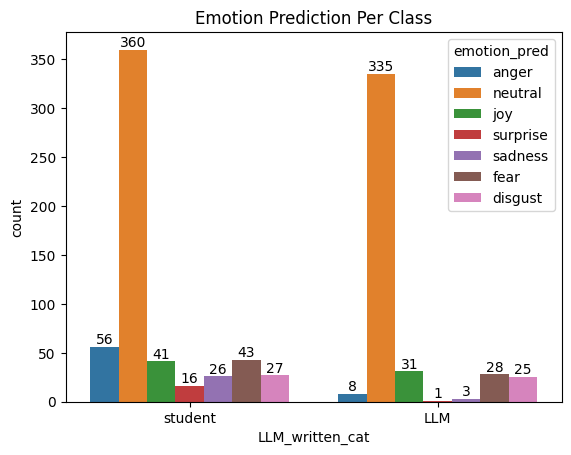

In [81]:
# Making a histogram
plt.title('Emotion Prediction Per Class')
plot = sns.countplot(sample,x='LLM_written_cat',hue='emotion_pred')
for i in plot.containers:
    plot.bar_label(i,)
plt.show()

In [103]:
# How the emotions are broken up for students
probs_given_student = sample[sample['LLM_written'] == 0]['emotion_pred'].value_counts() / sample[sample['LLM_written'] == 0].shape[0]
probs_given_student

emotion_pred
neutral     0.632689
anger       0.098418
fear        0.075571
joy         0.072056
disgust     0.047452
sadness     0.045694
surprise    0.028120
Name: count, dtype: float64

In [105]:
# How the emotions are broken up for LLM
probs_given_llm = sample[sample['LLM_written'] == 1]['emotion_pred'].value_counts() / sample[sample['LLM_written'] == 1].shape[0]
probs_given_llm

emotion_pred
neutral     0.777262
joy         0.071926
fear        0.064965
disgust     0.058005
anger       0.018561
sadness     0.006961
surprise    0.002320
Name: count, dtype: float64

In [107]:
# Overall probabilities
sample_probs = sample['emotion_pred'].value_counts() / sample.shape[0]
sample_probs

emotion_pred
neutral     0.695
joy         0.072
fear        0.071
anger       0.064
disgust     0.052
sadness     0.029
surprise    0.017
Name: count, dtype: float64

In [109]:
# Using bayes rule to find P(y = student | emotion) and P(y = llm | emotion)
total_probs = sample['LLM_written'].value_counts() / sample.shape[0]
student_given_emotion = (probs_given_student * total_probs[0]) / sample_probs 
llm_given_emotion = probs_given_llm * total_probs[1] / sample_probs 
student_given_emotion

emotion_pred
anger       0.875000
disgust     0.519231
fear        0.605634
joy         0.569444
neutral     0.517986
sadness     0.896552
surprise    0.941176
Name: count, dtype: float64

In [98]:
llm_given_emotion

emotion_pred
anger       0.125000
disgust     0.480769
fear        0.394366
joy         0.430556
neutral     0.482014
sadness     0.103448
surprise    0.058824
Name: count, dtype: float64

Analysis:

From the plot, I identified that student essays tend to have a lot more anger, surprise, and sadness emotions predicted. From this finding, I decided to utilize Bayes Rule to find P(Y|Emotion) for each Y and each emotion. The probabilities I found lined up with the findings from the plot: If an essay is predicted to have an angry tone, there is almost guranteed to be a student essay. The same can be said for sadness and surprise. For fear, whilst there are no gurantees, there is a higher chance for an essay to be a student's essay if it is predicted to exhibit fear. Disgust, joy, and neutral are relatively the same probabilities. 

TLDR: I need to add categorical features that mark whether an essay exhibits anger, surprise, sadness or fear. I found this to be suitable predictors.

In [111]:
# Closing connections and deleting the engine
db_conn.close()
db_engine.dispose()

2024-01-12 03:44:03,306 INFO sqlalchemy.engine.Engine ROLLBACK
